# FNC Model aplicado ao Oscilador Harmônico

Esse notebook contém o modelo de rede neural FNC (Fully Convolutional Network) aplicado ao oscilador harmônico, nos seus casos simples, forçado e amortecido forçado
## Overview

A equação diferencial que governa o problema, em 1 dimensão espacial, é dada por:
$$
m \dfrac{d^2 x}{d t^2} + \mu \dfrac{d x}{d t} + kx = 0~,
$$
Vamos considerar as condições iniciais dadas por:
$$
x(0) = 1~~,~~\dfrac{d x}{d t} = 0~.
$$

A solução para o oscilador harmônico simples é dada por:

$$
    x(t) = A\cos(\phi + \omega t)
$$

O caso de amortecimento ocorre quando os parâmetros admitem as seguintes condições:
$$
\delta < \omega_0~,~~~~~\mathrm{with}~~\delta = \dfrac{\mu}{2m}~,~\omega_0 = \sqrt{\dfrac{k}{m}}~.
$$
O que nos leva à solução:
$$
x(t) = e^{-\delta t}(2 A \cos(\phi + \omega t))~,~~~~~\mathrm{with}~~\omega=\sqrt{\omega_0^2 - \delta^2}~.
$$

No caso do amortecimento forçado, buscamos soluções da equação diferencial não-homogênea dada por

$$
m \dfrac{d^2 x}{d t^2} + \mu \dfrac{d x}{d t} + kx = \dfrac{F_{e}}{m}~,
$$

Onde $F_{e}$ seria uma força externa sobre o sistema dinâmico.

Nesse caso, a solução possui a forma:

$$
x(t) = e^{-\delta t}(2 A \cos(\phi + \omega t))~ + \dfrac{B\cos{\omega_{e}t}}{m(\omega_{e}^{2} - \omega^{2})}.
$$

<!-- We will focus on solving the problem for the under-damped state, i.e. when 
$$
\delta < \omega_0~,~~~~~\mathrm{with}~~\delta = \dfrac{\mu}{2m}~,~\omega_0 = \sqrt{\dfrac{k}{m}}~.
$$
This has the following exact solution:
$$
x(t) = e^{-\delta t}(2 A \cos(\phi + \omega t))~,~~~~~\mathrm{with}~~\omega=\sqrt{\omega_0^2 - \delta^2}~.
$$ -->

# Import modules

In [7]:
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Utils
Some utils functions used in the simulation

In [8]:
def saveGif(outfile, files, fps=5, loop=0):
    "Helper function for saving GIFs"
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)

def plotResult(x, y, x_data, y_data, labelY, labelY_data, title, fileName, yLimInf = -1, yLimSup = 1):
    plt.style.use('default')
    fig1 = plt.figure(figsize=(8,6))
    axes = fig1.add_axes([0.1,0.1,0.8,0.8])

    axes.plot(x, y, label=labelY)
    axes.scatter(x_data, y_data, color="tab:orange", label=labelY_data)
    
    axes.set_xlabel('Time')
    axes.set_ylabel('Solution')

    axes.set_title(title)
    plt.ylim([yLimInf, yLimSup])
    plt.legend()
    plt.grid(linestyle='-', linewidth=0.5)
    plt.savefig(fileName, dpi=400)


def plotPrettyResult(x,y,x_data,y_data,yh,xp=None):
    "Pretty plot training results"
    plt.figure(figsize=(8,4))
    plt.plot(x,y, color="grey", linewidth=2, alpha=0.8, label="Exact solution")
    plt.plot(x,yh, color="tab:blue", linewidth=4, alpha=0.8, label="Neural network prediction")
    plt.scatter(x_data, y_data, s=60, color="tab:orange", alpha=0.4, label='Training data')
    if xp is not None:
        plt.scatter(xp, -0*torch.ones_like(xp), s=30, color="tab:green", alpha=0.4, 
                    label='Physics loss training locations')
    l = plt.legend(loc=(1.01,0.34), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.xlim(-0.05, 1.05)
    plt.ylim(-1.1, 1.1)
    plt.text(1.065,0.7,"Training step: %i"%(i+1),fontsize="xx-large",color="k")
    plt.axis("off")

# Define the analytical solutions as functions

In [9]:
def oscillatorSimple(d, w0, x):
    phi = np.arctan(-d/w0)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w0*x)
    y  = A*cos
    return y


def oscillatorDumped(d, w0, x):
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*x)
    sin = torch.sin(phi+w*x)
    exp = torch.exp(-d*x)
    y  = exp*2*A*cos
    return y

def oscillatorDumpedForced(d, w0, x):
    assert d < w0
    m = 1/(2*d)
    w = np.sqrt(w0**2-d**2)
    wE = 0.98*w
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    B = 4.0
    cos = torch.cos(phi+w*x)
    cosWe = torch.cos(wE*x)
    sin = torch.sin(phi+w*x)
    exp = torch.exp(-d*x)
    y  = exp*2*A*cos + (B*cosWe)/(m*(wE*wE - w*w))
    return y

# Define the Fully Convolutional Network (FNC)

In [10]:
class FCN(nn.Module):
    "Defines a connected network"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

# Generate training data for the model

## Simple oscillator

torch.Size([500, 1]) torch.Size([500, 1])
torch.Size([10, 1]) torch.Size([10, 1])


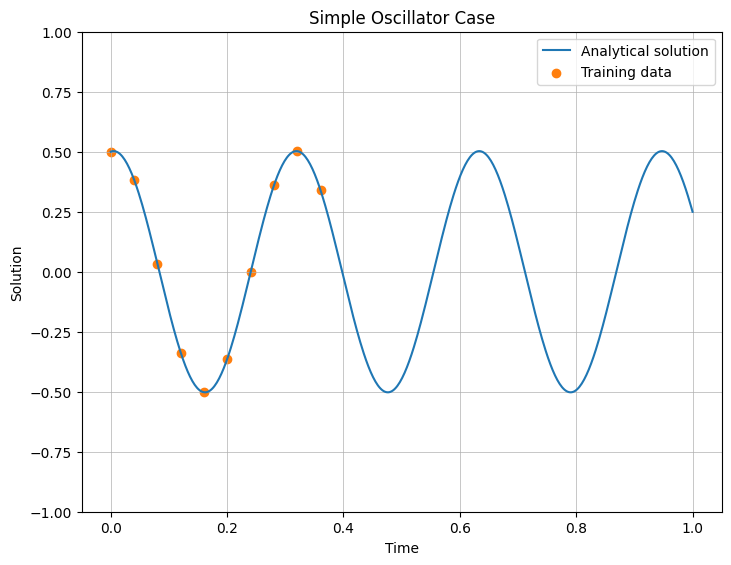

In [11]:
d, w0 = 2, 20

x = torch.linspace(0,1,500).view(-1,1)
y = oscillatorSimple(d, w0, x).view(-1,1)
print(x.shape, y.shape)

x_data = x[0:200:20]
y_data = y[0:200:20]
print(x_data.shape, y_data.shape)

plotResult(x, y, x_data, y_data, 'Analytical solution', 'Training data', 'Simple Oscillator Case', 'plots/simpleOscCaseTraining1.png')

### Training the standard neural network using FNC for simple oscillator case

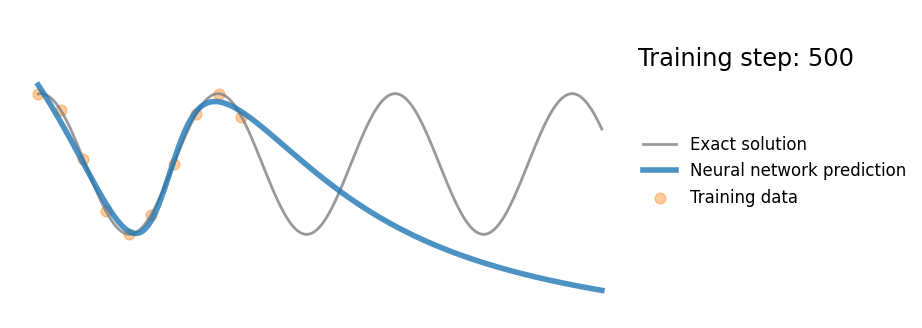

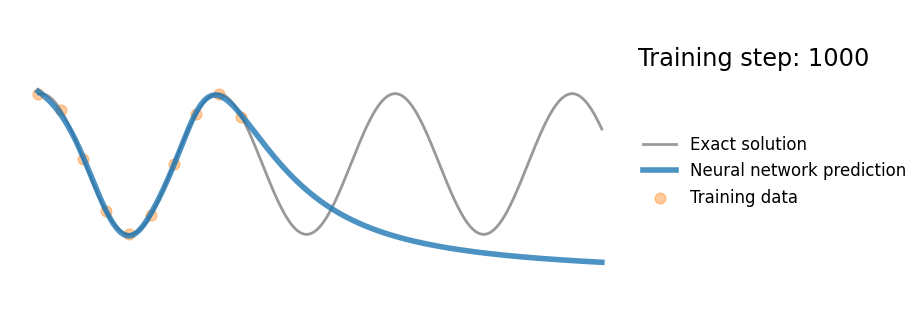

In [12]:
torch.manual_seed(123)
model = FCN(1,1,32,3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
files = []
for i in range(1000):
    optimizer.zero_grad()
    yh = model(x_data)
    loss = torch.mean((yh-y_data)**2)
    loss.backward()
    optimizer.step()
    
    if (i+1) % 10 == 0: 
        
        yh = model(x).detach()
        
        plotPrettyResult(x,y,x_data,y_data,yh)
        
        file = "plots/plotsToGif/nn_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
    
        if (i+1) % 500 == 0: plt.show()
        else: plt.close("all")
            
saveGif("oscStdCase.gif", files, fps=20, loop=0)

### Training the physical neural network for the simple oscillator case

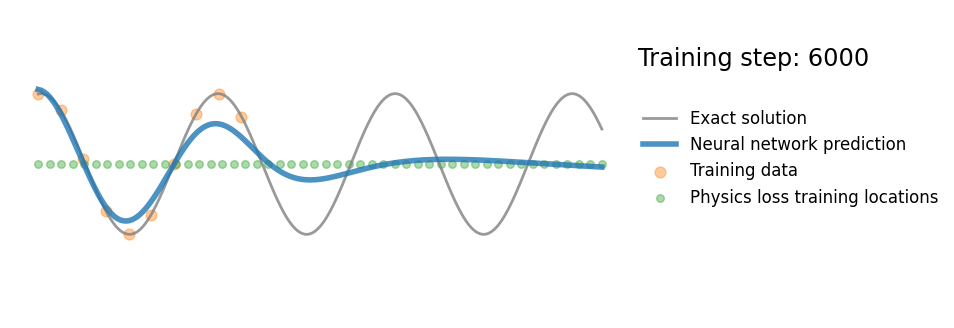

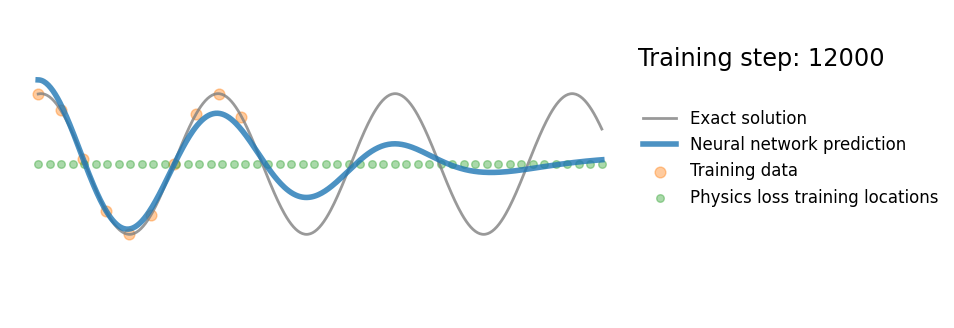

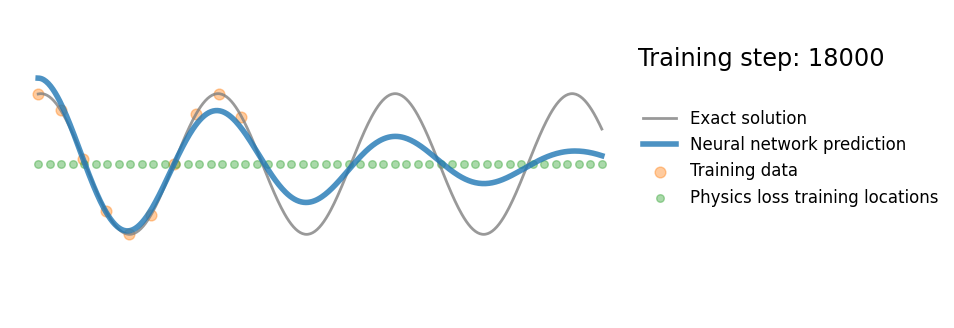

In [13]:
x_physics = torch.linspace(0,1,50).view(-1,1).requires_grad_(True)# sample gerado a partir do espaçamento dos pontos no domínio
mu, k = 2*d, w0**2

torch.manual_seed(123)
model = FCN(1,1,32,3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
files = []
for i in range(20000):
    optimizer.zero_grad()
    
    # Calcula o "data loss"
    yh = model(x_data)
    loss1 = torch.mean((yh-y_data)**2)
    
    # Calcula o "physics loss"
    yhp = model(x_physics)
    dx  = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]# computes dy/dx
    dx2 = torch.autograd.grad(dx,  x_physics, torch.ones_like(dx),  create_graph=True)[0]# computes d^2y/dx^2
    physics = dx2 + mu*dx + k*yhp # utiliza as derivadas para simular a solução a partir da equação diferencial
    loss2 = (1e-4)*torch.mean(physics**2)
    
    
    loss = loss1 + loss2
    loss.backward()
    optimizer.step()
    
    
   
    if (i+1) % 150 == 0: 
        
        yh = model(x).detach()
        xp = x_physics.detach()
        
        plotPrettyResult(x,y,x_data,y_data,yh,xp)
        
        file = "plots/plotsToGif/pinn_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
        
        if (i+1) % 6000 == 0: plt.show()
        else: plt.close("all")
            
saveGif("oscPNNCase.gif", files, fps=20, loop=0)

Dumped oscillator

torch.Size([500, 1]) torch.Size([500, 1])
torch.Size([10, 1]) torch.Size([10, 1])


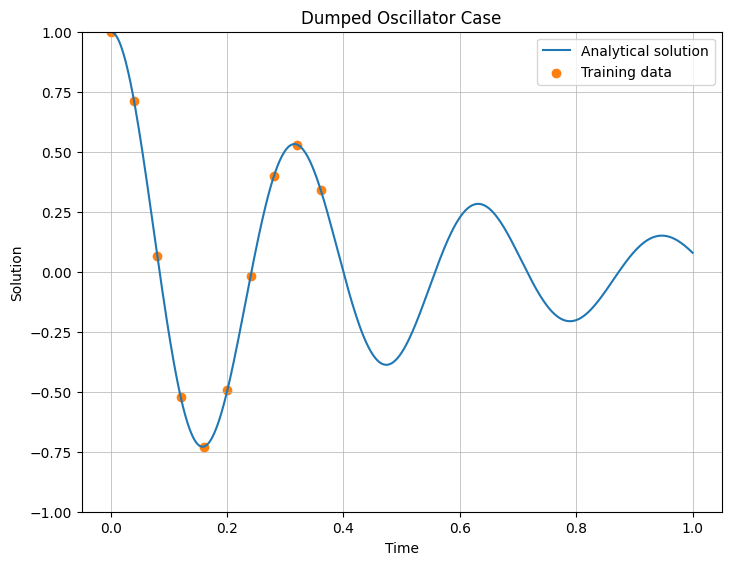

In [14]:
d, w0 = 2, 20

x = torch.linspace(0,1,500).view(-1,1)
y = oscillatorDumped(d, w0, x).view(-1,1)
print(x.shape, y.shape)

x_data = x[0:200:20]
y_data = y[0:200:20]
print(x_data.shape, y_data.shape)

plotResult(x, y, x_data, y_data, 'Analytical solution', 'Training data', 'Dumped Oscillator Case', 'plots/dumpedOscCaseTraining.png')

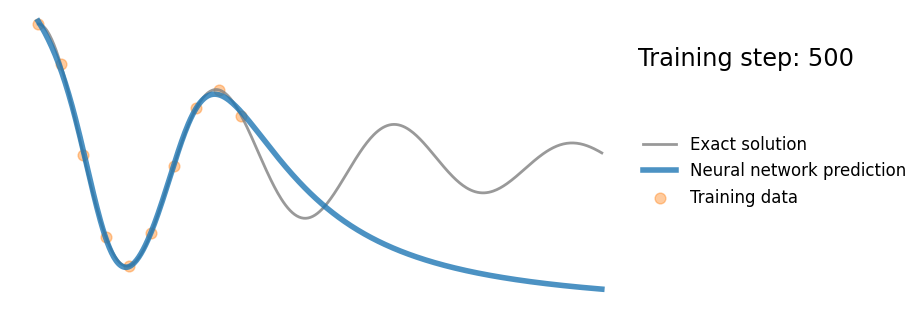

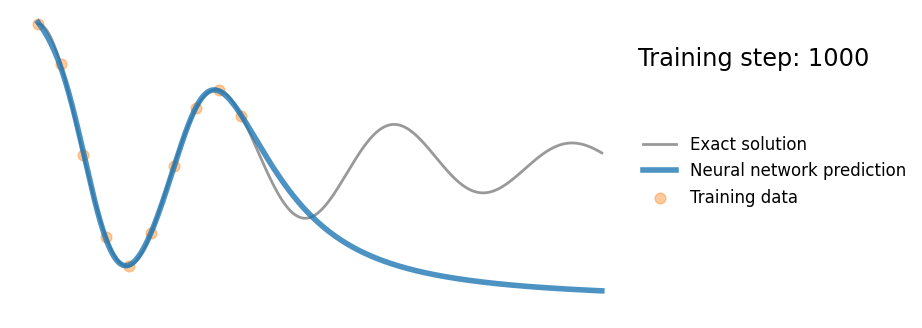

In [15]:
torch.manual_seed(123)
model = FCN(1,1,32,3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
files = []
for i in range(1000):
    optimizer.zero_grad()
    yh = model(x_data)
    loss = torch.mean((yh-y_data)**2)
    loss.backward()
    optimizer.step()
    
    
    
    if (i+1) % 10 == 0: 
        
        yh = model(x).detach()
        
        plotPrettyResult(x,y,x_data,y_data,yh)
        
        file = "plots/plotsToGif/nn_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
    
        if (i+1) % 500 == 0: plt.show()
        else: plt.close("all")
            
saveGif("oscDumpedStdCase.gif", files, fps=20, loop=0)

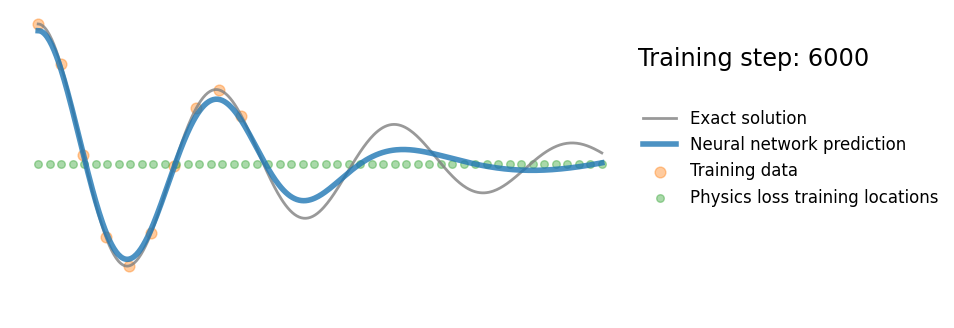

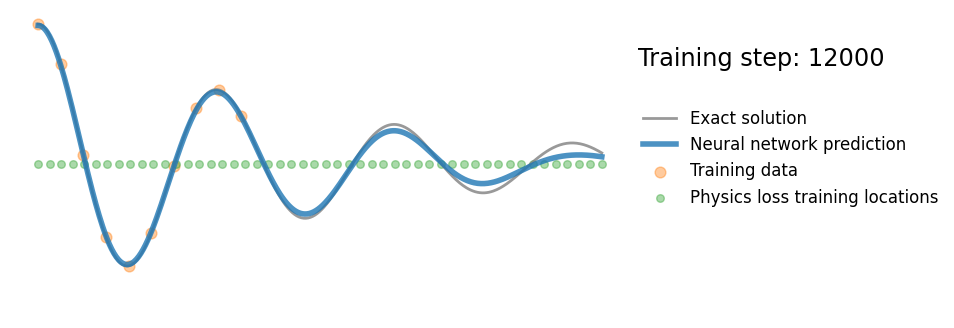

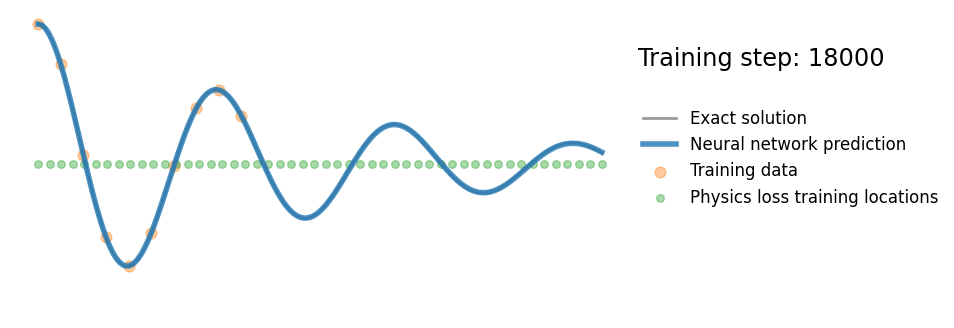

In [16]:
x_physics = torch.linspace(0,1,50).view(-1,1).requires_grad_(True)
mu, k = 2*d, w0**2

torch.manual_seed(123)
model = FCN(1,1,32,3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
files = []
for i in range(20000):
    optimizer.zero_grad()
    
    
    yh = model(x_data)
    loss1 = torch.mean((yh-y_data)**2)
    
    
    yhp = model(x_physics)
    dx  = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]
    dx2 = torch.autograd.grad(dx,  x_physics, torch.ones_like(dx),  create_graph=True)[0]
    physics = dx2 + mu*dx + k*yhp
    loss2 = (1e-4)*torch.mean(physics**2)
    
   
    loss = loss1 + loss2
    loss.backward()
    optimizer.step()
    
    
    
    if (i+1) % 150 == 0: 
        
        yh = model(x).detach()
        xp = x_physics.detach()
        
        plotPrettyResult(x,y,x_data,y_data,yh,xp)
        
        file = "plots/plotsToGif/pinn_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
        
        if (i+1) % 6000 == 0: plt.show()
        else: plt.close("all")
            
saveGif("oscDumpedPNNCase.gif", files, fps=20, loop=0)

Forced dumped oscillator

torch.Size([500, 1]) torch.Size([500, 1])
torch.Size([10, 1]) torch.Size([10, 1])


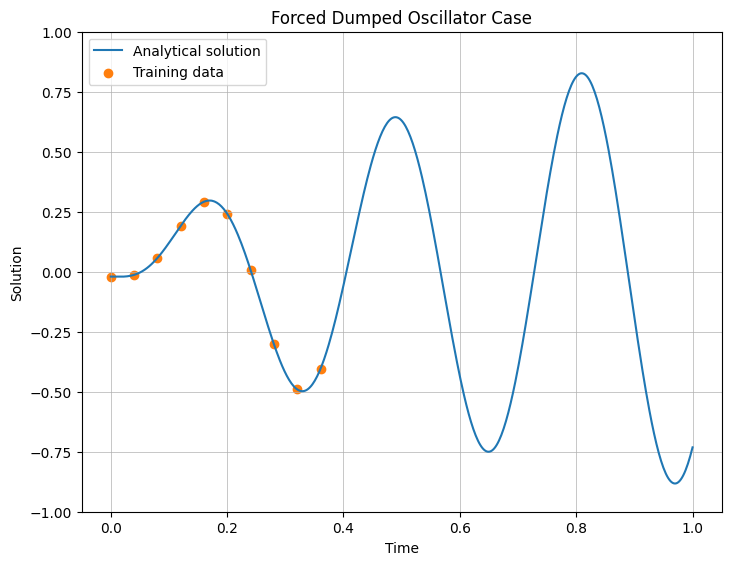

In [17]:
d, w0 = 2, 20

x = torch.linspace(0,1,500).view(-1,1)
y = oscillatorDumpedForced(d, w0, x).view(-1,1)
print(x.shape, y.shape)

x_data = x[0:200:20]
y_data = y[0:200:20]
print(x_data.shape, y_data.shape)

plotResult(x, y, x_data, y_data, 'Analytical solution', 'Training data', 'Forced Dumped Oscillator Case', 'plots/forcedDumpedOscCaseTraining.png')

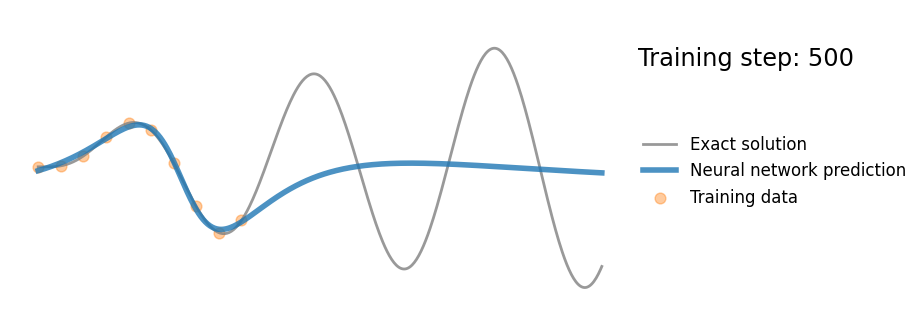

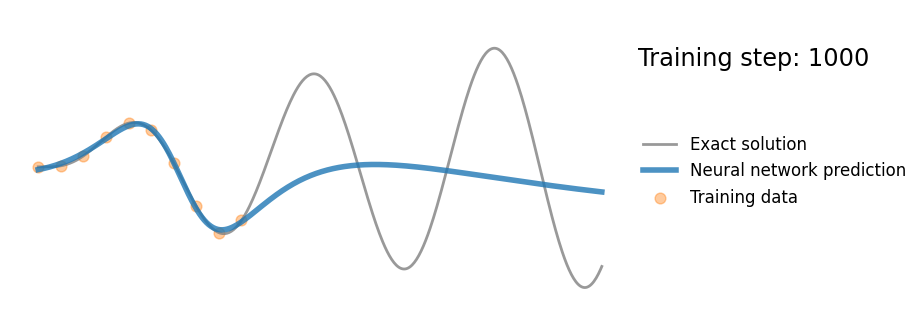

In [18]:

torch.manual_seed(123)
model = FCN(1,1,32,3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
files = []
for i in range(1000):
    optimizer.zero_grad()
    yh = model(x_data)
    loss = torch.mean((yh-y_data)**2)
    loss.backward()
    optimizer.step()
    
    
    
    if (i+1) % 10 == 0: 
        
        yh = model(x).detach()
        
        plotPrettyResult(x,y,x_data,y_data,yh)
        
        file = "plots/plotsToGif/nn_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
    
        if (i+1) % 500 == 0: plt.show()
        else: plt.close("all")
            
saveGif("oscForcedDumpedStdCase.gif", files, fps=20, loop=0)

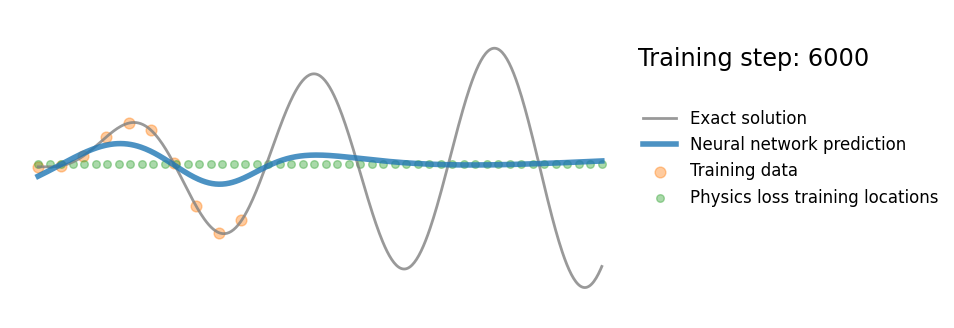

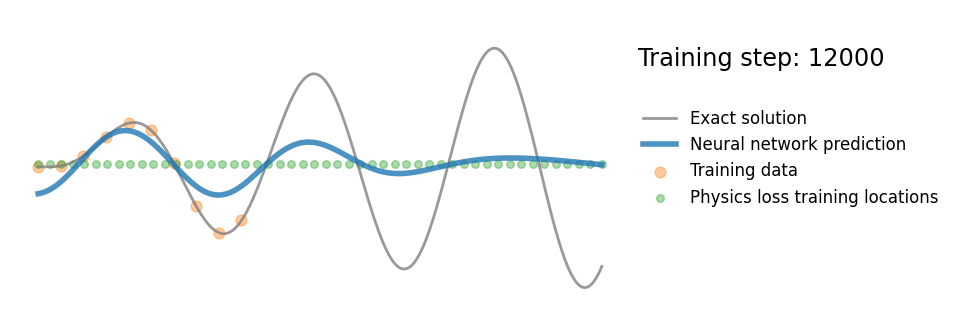

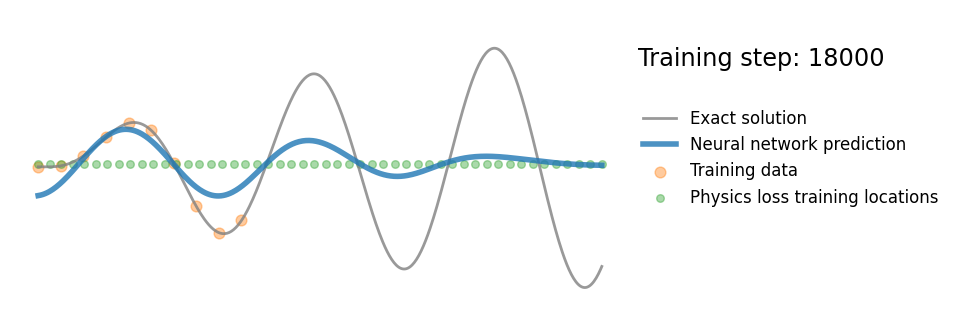

In [19]:
x_physics = torch.linspace(0,1,50).view(-1,1).requires_grad_(True)
mu, k = 2*d, w0**2
m = 1/2*d
B = 4.0

torch.manual_seed(123)
model = FCN(1,1,32,3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
files = []
for i in range(20000):
    optimizer.zero_grad()
    
    
    yh = model(x_data)
    loss1 = torch.mean((yh-y_data)**2)
    
    
    yhp = model(x_physics)
    dx  = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]
    dx2 = torch.autograd.grad(dx,  x_physics, torch.ones_like(dx),  create_graph=True)[0]
    physics = dx2 + mu*dx + k*yhp - B/m 
    loss2 = (1e-4)*torch.mean(physics**2)
    
    
    loss = loss1 + loss2
    loss.backward()
    optimizer.step()
    
    
    
    if (i+1) % 150 == 0: 
        
        yh = model(x).detach()
        xp = x_physics.detach()
        
        plotPrettyResult(x,y,x_data,y_data,yh,xp)
        
        file = "plots/plotsToGif/pinn_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
        
        if (i+1) % 6000 == 0: plt.show()
        else: plt.close("all")
            
saveGif("oscForcedDumpedPNNCase.gif", files, fps=20, loop=0)